In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import factor_analyzer
import pickle

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv("historical-featured.csv")
data = data.drop('Unnamed: 0', axis=1)
data.head()

,ID,Venue,T1_Mat,T1_AvgRunsScored,T1_AvgRunsConceded,T1_AvgWktsTaken,T1_AvgWktsLost,T1_AvgBound,T1_W/L,T2_Mat,T2_AvgRunsScored,T2_AvgRunsConceded,T2_AvgWktsTaken,T2_AvgWktsLost,T2_AvgBound,T2_W/L,Winner
0,1,Africa,34,7.10,7.27,0.33,0.32,0.85,1.833,22,7.69,7.99,0.28,0.32,0.95,1.000,0
1,2,Oceania,36,8.01,7.38,0.35,0.33,0.98,1.400,30,7.56,7.70,0.32,0.32,0.93,1.142,0
2,3,Oceania,37,8.00,7.39,0.35,0.33,0.98,1.312,31,7.56,7.70,0.32,0.33,0.93,1.214,1
3,4,America,38,7.14,7.18,0.33,0.34,0.84,1.235,24,7.13,8.08,0.29,0.36,0.89,0.714,0
4,5,America,23,7.71,7.94,0.28,0.32,0.96,1.090,25,7.13,8.04,0.29,0.36,0.89,0.785,1


In [3]:
# train test split
train, test= train_test_split(data, test_size = 0.2, random_state = 100)

In [4]:
train.shape, test.shape

((415, 17), (104, 17))

In [5]:
train.columns

Index(['ID', 'Venue', 'T1_Mat', 'T1_AvgRunsScored', 'T1_AvgRunsConceded',
       'T1_AvgWktsTaken', 'T1_AvgWktsLost', 'T1_AvgBound', 'T1_W/L', 'T2_Mat',
       'T2_AvgRunsScored', 'T2_AvgRunsConceded', 'T2_AvgWktsTaken',
       'T2_AvgWktsLost', 'T2_AvgBound', 'T2_W/L', 'Winner'],
      dtype='object')

In [6]:
train.dtypes

ID                      int64
Venue                  object
T1_Mat                  int64
T1_AvgRunsScored      float64
T1_AvgRunsConceded    float64
T1_AvgWktsTaken       float64
T1_AvgWktsLost        float64
T1_AvgBound           float64
T1_W/L                float64
T2_Mat                  int64
T2_AvgRunsScored      float64
T2_AvgRunsConceded    float64
T2_AvgWktsTaken       float64
T2_AvgWktsLost        float64
T2_AvgBound           float64
T2_W/L                float64
Winner                  int64
dtype: object

In [7]:
num = train.select_dtypes(include='number')
num.columns

Index(['ID', 'T1_Mat', 'T1_AvgRunsScored', 'T1_AvgRunsConceded',
       'T1_AvgWktsTaken', 'T1_AvgWktsLost', 'T1_AvgBound', 'T1_W/L', 'T2_Mat',
       'T2_AvgRunsScored', 'T2_AvgRunsConceded', 'T2_AvgWktsTaken',
       'T2_AvgWktsLost', 'T2_AvgBound', 'T2_W/L', 'Winner'],
      dtype='object')

## Model training

In [10]:
new_var = train.drop(['Winner', 'ID', 'Venue', 
                       'T2_AvgRunsScored', 'T2_AvgWktsLost', 'T2_AvgBound', 
                       'T1_AvgRunsScored', 'T1_AvgBound',
                       'T1_Mat',
                       'T1_W/L', 'T1_AvgWktsTaken', 'T2_W/L'],axis=1) 
new_var.columns

Index(['T1_AvgRunsConceded', 'T1_AvgWktsLost', 'T2_Mat', 'T2_AvgRunsConceded',
       'T2_AvgWktsTaken'],
      dtype='object')

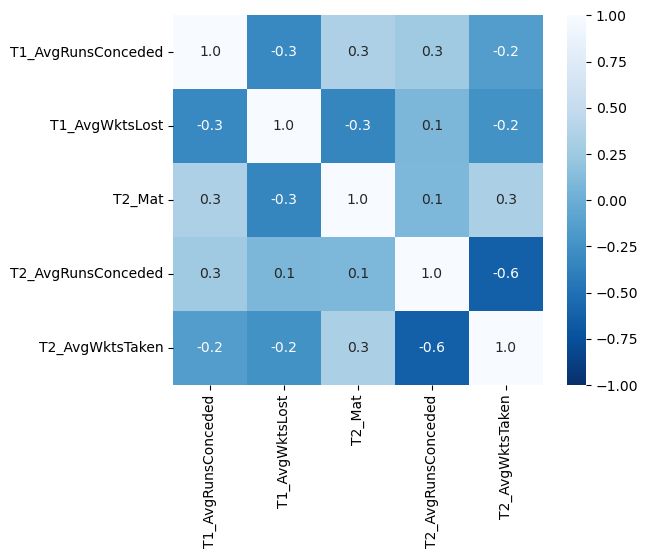

{'corr':                     T1_AvgRunsConceded  T1_AvgWktsLost    T2_Mat  \
 T1_AvgRunsConceded            1.000000       -0.325141  0.340470   
 T1_AvgWktsLost               -0.325141        1.000000 -0.344855   
 T2_Mat                        0.340470       -0.344855  1.000000   
 T2_AvgRunsConceded            0.257196        0.085663  0.093168   
 T2_AvgWktsTaken              -0.153539       -0.249643  0.332178   
 
                     T2_AvgRunsConceded  T2_AvgWktsTaken  
 T1_AvgRunsConceded            0.257196        -0.153539  
 T1_AvgWktsLost                0.085663        -0.249643  
 T2_Mat                        0.093168         0.332178  
 T2_AvgRunsConceded            1.000000        -0.626364  
 T2_AvgWktsTaken              -0.626364         1.000000  ,
 'ax': <AxesSubplot:>}

In [11]:
# dython - all the variables
from dython.nominal import associations
associations(new_var, fmt='.1f', cmap='Blues_r')

In [12]:
xtrain = train.drop(['Winner', 'ID', 'Venue', 
                       'T2_AvgRunsScored', 'T2_AvgWktsLost', 'T2_AvgBound', 
                       'T1_AvgRunsScored', 'T1_AvgBound',
                       'T1_Mat',
                       'T1_W/L', 'T1_AvgWktsTaken', 'T2_W/L'],axis=1) 
ytrain = train['Winner']
 
xtest = test.drop(['Winner', 'ID', 'Venue', 
                       'T2_AvgRunsScored', 'T2_AvgWktsLost', 'T2_AvgBound', 
                       'T1_AvgRunsScored', 'T1_AvgBound',
                       'T1_Mat',
                       'T1_W/L', 'T1_AvgWktsTaken', 'T2_W/L'],axis=1)  
ytest = test['Winner']

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((415, 5), (104, 5), (415,), (104,))

In [13]:
st = StandardScaler()
xtrain  = st.fit_transform( xtrain)
xtest = st.fit_transform( xtest)

In [14]:
sm = SMOTE(random_state=42)
xtrain_sm, ytrain_sm = sm.fit_resample(  xtrain,ytrain) 
 
xtrain_sm.shape, ytrain_sm.shape 

((486, 5), (486,))

## Logistic regression - with hyperparameter tuning

## Ridge

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [19]:
logModel  = LogisticRegression(random_state=42)
param_grid = [    
    {'solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'penalty' : [   'l2' ], #'None', 'l1', 'l2', 'elasticnet'
    'C' :  [1e-3 ],
    'max_iter': [2000]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(logModel, param_grid = param_grid , verbose=True, n_jobs=-1, cv=cv , scoring='f1')
grid_result = grid_search.fit(xtrain_sm,ytrain_sm)

Fitting 30 folds for each of 6 candidates, totalling 180 fits


In [20]:
grid_search.best_estimator_

LogisticRegression(C=0.001, max_iter=2000, random_state=42, solver='liblinear')

In [21]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'},
 0.5624571548354165)

In [22]:
# Predict the train data
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       243
           1       0.58      0.56      0.57       243

    accuracy                           0.58       486
   macro avg       0.58      0.58      0.58       486
weighted avg       0.58      0.58      0.58       486

LogReg: ROC AUC =  57.6 %
LogReg: Precision =  57.9 %
LogReg: Recall =  56.0 %
LogReg: Accuracy =  57.6 %
LogReg: F1-Score =  56.9 %


array([[144,  99],
       [107, 136]], dtype=int64)

In [23]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        49
           1       0.59      0.55      0.57        55

    accuracy                           0.56       104
   macro avg       0.56      0.56      0.56       104
weighted avg       0.56      0.56      0.56       104

LogReg: ROC AUC =  55.8 %
LogReg: Precision =  58.8 %
LogReg: Recall =  54.5 %
LogReg: Accuracy =  55.8 %
LogReg: F1-Score =  56.6 %


array([[28, 21],
       [25, 30]], dtype=int64)

In [50]:
# filename = 'LR-Ridge+SMOTE+FA-New.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

## Lasso

In [24]:
logModel  = LogisticRegression(random_state=42)
param_grid = [    
    {'solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'penalty' : [   'l1'  ], #'None', 'l1', 'l2', 'elasticnet'
    'C' :  [1e-1],
    'max_iter': [2000]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search= GridSearchCV(logModel, param_grid = param_grid , verbose=True, n_jobs=-1, cv=cv , scoring='f1')
grid_result = grid_search.fit(xtrain_sm,ytrain_sm)

Fitting 30 folds for each of 6 candidates, totalling 180 fits


In [25]:
grid_search.best_estimator_

LogisticRegression(C=0.1, max_iter=2000, penalty='l1', random_state=42,
                   solver='saga')

In [26]:
# Predict the train data
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       243
           1       0.59      0.61      0.60       243

    accuracy                           0.60       486
   macro avg       0.60      0.60      0.60       486
weighted avg       0.60      0.60      0.60       486

 ROC AUC =  59.7 %
 Precision =  59.4 %
 Recall =  61.3 %
 Accuracy =  59.7 %
 F1-Score =  60.3 %


array([[141, 102],
       [ 94, 149]], dtype=int64)

In [27]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

           0       0.54      0.51      0.53        49
           1       0.59      0.62      0.60        55

    accuracy                           0.57       104
   macro avg       0.56      0.56      0.56       104
weighted avg       0.57      0.57      0.57       104

LogReg: ROC AUC =  56.4 %
LogReg: Precision =  58.6 %
LogReg: Recall =  61.8 %
LogReg: Accuracy =  56.7 %
LogReg: F1-Score =  60.2 %


array([[25, 24],
       [21, 34]], dtype=int64)

In [24]:
# filename = 'LR-Lasso+SMOTE+FA-New.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

## elasticnet

In [32]:
logModel  = LogisticRegression(random_state=42)
param_grid = [    
    {'solver' : [ 'saga'],
    'penalty' : [   'elasticnet'  ], #'None', 'l1', 'l2', 'elasticnet'
    'C' :  [1],
    'max_iter': [2000],
    'l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
log_grid = GridSearchCV(logModel, param_grid = param_grid , verbose=True, n_jobs=-1, cv=cv , scoring='f1')
log_clf_hyp = log_grid.fit(xtrain_sm,ytrain_sm)

Fitting 30 folds for each of 9 candidates, totalling 270 fits


In [33]:
log_clf_hyp.best_estimator_

LogisticRegression(C=1, l1_ratio=0.1, max_iter=2000, penalty='elasticnet',
                   random_state=42, solver='saga')

In [34]:
# Predict the train data
y_predicted = log_clf_hyp.predict(xtrain_sm)

print('\nclassification report-logistic(enet)+SMOTE-train')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report-logistic(enet)+SMOTE-train
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       243
           1       0.61      0.61      0.61       243

    accuracy                           0.61       486
   macro avg       0.61      0.61      0.61       486
weighted avg       0.61      0.61      0.61       486

LogReg: ROC AUC =  60.9 %
LogReg: Precision =  60.9 %
LogReg: Recall =  60.9 %
LogReg: Accuracy =  60.9 %
LogReg: F1-Score =  60.9 %


array([[148,  95],
       [ 95, 148]], dtype=int64)

In [35]:
# Predict the test data
y_predicted = log_clf_hyp.predict( xtest)

print('\nclassification report-logistic(enet)+SMOTE-test')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report-logistic(enet)+SMOTE-test
              precision    recall  f1-score   support

           0       0.57      0.61      0.59        49
           1       0.63      0.58      0.60        55

    accuracy                           0.60       104
   macro avg       0.60      0.60      0.60       104
weighted avg       0.60      0.60      0.60       104

LogReg: ROC AUC =  59.7 %
LogReg: Precision =  62.7 %
LogReg: Recall =  58.2 %
LogReg: Accuracy =  59.6 %
LogReg: F1-Score =  60.4 %


array([[30, 19],
       [23, 32]], dtype=int64)

In [195]:
# filename = 'LR-Enet+SMOTE+FA-New.pkl'
# pickle.dump(log_clf_hyp, open(filename, 'wb'))

## SVM with hyperparameter tuning

### SVM

In [36]:
from sklearn.svm import SVC

In [87]:
# define model
model = SVC(random_state=42)

# define grid search
param_grid = [    
    {'kernel' : ['poly', 'linear', 'rbf', 'sigmoid' ],
     'degree' : [3],
     'gamma' :['scale', 'auto' ],
    'C': [1e-1]
 
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=True, n_jobs=-1, cv=cv , scoring = 'f1', error_score=0)
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

Fitting 30 folds for each of 8 candidates, totalling 240 fits


In [88]:
grid_search.best_estimator_

SVC(C=0.1, random_state=42)

In [89]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'},
 0.5816852445543326)

In [90]:
# Predict the train data
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report- SVM+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) 
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report- SVM+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.59      0.51      0.55       243
           1       0.57      0.65      0.61       243

    accuracy                           0.58       486
   macro avg       0.58      0.58      0.58       486
weighted avg       0.58      0.58      0.58       486

 ROC AUC =  57.8 %
 Precision =  56.8 %
 Recall =  65.0 %
 Accuracy =  57.8 %
 F1-Score =  60.7 %


array([[123, 120],
       [ 85, 158]], dtype=int64)

In [91]:
# Predict the test data
y_predicted = grid_search.predict(xtest)

print('\nclassification report- SVM+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted))  
print(' ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- SVM+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.54      0.51      0.53        49
           1       0.59      0.62      0.60        55

    accuracy                           0.57       104
   macro avg       0.56      0.56      0.56       104
weighted avg       0.57      0.57      0.57       104

 ROC AUC =  56.4 %
 Precision =  58.6 %
 Recall =  61.8 %
 Accuracy =  56.7 %
 F1-Score =  60.2 %


array([[25, 24],
       [21, 34]], dtype=int64)

In [72]:
# filename = 'SVM+SMOTE+FA-New.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

## KNN

In [92]:
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization

In [93]:
pipe = Pipeline([
('classifier', KNeighborsClassifier())
])

In [200]:
parameters = { 
 'classifier__n_neighbors': [17],
 'classifier__p': [1, 2],
 'classifier__leaf_size':   [1, 5, 10, 15],
 'classifier__weights': ['uniform'  ],
 'classifier__metric' : ['euclidean', 'manhattan', 'minkowski']
}

In [201]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(pipe, parameters,verbose=True, n_jobs=-1, cv=cv , scoring = 'f1', error_score=0).fit(xtrain_sm  , ytrain_sm  )

Fitting 30 folds for each of 24 candidates, totalling 720 fits


In [202]:
grid.best_params_, grid.best_score_

({'classifier__leaf_size': 1,
  'classifier__metric': 'euclidean',
  'classifier__n_neighbors': 17,
  'classifier__p': 1,
  'classifier__weights': 'uniform'},
 0.5372225779807402)

In [203]:
y_predicted = grid.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.62      0.67      0.64       243
           1       0.64      0.59      0.62       243

    accuracy                           0.63       486
   macro avg       0.63      0.63      0.63       486
weighted avg       0.63      0.63      0.63       486

 ROC AUC =  63.0 %
 Precision =  64.0 %
 Recall =  59.3 %
 Accuracy =  63.0 %
 F1-Score =  61.5 %


array([[162,  81],
       [ 99, 144]], dtype=int64)

In [204]:
# Predict the test data
y_predicted = grid.predict(xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.57      0.67      0.62        49
           1       0.65      0.55      0.59        55

    accuracy                           0.61       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.61      0.61      0.60       104

Random Forest: ROC AUC =  60.9 %
Random Forest: Precision =  65.2 %
Random Forest: Recall =  54.5 %
Random Forest: Accuracy =  60.6 %
Random Forest: F1-Score =  59.4 %


array([[33, 16],
       [25, 30]], dtype=int64)

## GNB

In [240]:
import random

def set_random_seed(seed=100):
  np.random.seed(seed)
  random.seed(seed)
    
set_random_seed(100)

In [244]:
from sklearn.naive_bayes import GaussianNB

gnb_clf_hyp = GaussianNB(var_smoothing=100) 
gnb_clf_hyp.fit(xtrain_sm, ytrain_sm)

GaussianNB(var_smoothing=100)

In [245]:
y_predicted = gnb_clf_hyp.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.58      0.65      0.61       243
           1       0.60      0.53      0.57       243

    accuracy                           0.59       486
   macro avg       0.59      0.59      0.59       486
weighted avg       0.59      0.59      0.59       486

 ROC AUC =  59.3 %
 Precision =  60.5 %
 Recall =  53.5 %
 Accuracy =  59.3 %
 F1-Score =  56.8 %


array([[158,  85],
       [113, 130]], dtype=int64)

In [246]:
# Predict the test data
y_predicted = gnb_clf_hyp.predict(xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.54      0.61      0.57        49
           1       0.60      0.53      0.56        55

    accuracy                           0.57       104
   macro avg       0.57      0.57      0.57       104
weighted avg       0.57      0.57      0.57       104

Random Forest: ROC AUC =  57.0 %
Random Forest: Precision =  60.4 %
Random Forest: Recall =  52.7 %
Random Forest: Accuracy =  56.7 %
Random Forest: F1-Score =  56.3 %


array([[30, 19],
       [26, 29]], dtype=int64)

## Random Forest

## random forest - with hyperparameter tuning

In [277]:
# xtrain = train.drop(['Winner', 'ID', 'Venue', 
#                        'T2_AvgRunsScored/Over', 'T2_Avg_Wkts_Lost', 'T2_Bound', 
#                        'T1_AvgRunsScored/Over', 'T1_Bound',
#                        'T1_Mat',
#                        'T1_W/L', 'T1_Avg_Wkts_Taken'],axis=1) 
# ytrain = train['Winner']
 
# xtest = test.drop(['Winner', 'ID', 'Venue', 
#                       'T2_AvgRunsScored/Over', 'T2_Avg_Wkts_Lost', 'T2_Bound', 
#                        'T1_AvgRunsScored/Over', 'T1_Bound',
#                        'T1_Mat',
#                        'T1_W/L', 'T1_Avg_Wkts_Taken'],axis=1)  
# ytest = test['Winner']

# st = StandardScaler()
# xtrain  = st.fit_transform( xtrain)
# xtest = st.fit_transform( xtest)

# sm = SMOTE(random_state=100)
# xtrain_sm, ytrain_sm = sm.fit_resample(  xtrain,ytrain) 

In [247]:
# explore random forest bootstrap sample size on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV # For optimization

In [300]:
# define models and parameters
model = RandomForestClassifier(random_state=42)
param_grid = [    
    {'n_estimators' : [2000],
    'criterion': ['entropy'],
    'max_features':[0.2], #0.2
     'min_samples_leaf': [ 40 ], #70
     'oob_score':[True],
     'min_samples_split':[6] #6
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= param_grid, n_jobs=-1,  cv=cv, scoring='f1',error_score='raise')
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

In [301]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_features=0.2,
                       min_samples_leaf=40, min_samples_split=6,
                       n_estimators=2000, oob_score=True, random_state=42)

In [304]:
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.62      0.57      0.60       243
           1       0.60      0.65      0.63       243

    accuracy                           0.61       486
   macro avg       0.61      0.61      0.61       486
weighted avg       0.61      0.61      0.61       486

 ROC AUC =  61.3 %
 Precision =  60.5 %
 Recall =  65.4 %
 Accuracy =  61.3 %
 F1-Score =  62.8 %


array([[139, 104],
       [ 84, 159]], dtype=int64)

In [302]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.58      0.59      0.59        49
           1       0.63      0.62      0.62        55

    accuracy                           0.61       104
   macro avg       0.60      0.61      0.60       104
weighted avg       0.61      0.61      0.61       104

Random Forest: ROC AUC =  60.5 %
Random Forest: Precision =  63.0 %
Random Forest: Recall =  61.8 %
Random Forest: Accuracy =  60.6 %
Random Forest: F1-Score =  62.4 %


array([[29, 20],
       [21, 34]], dtype=int64)

In [303]:
# filename = 'RF+SMOTE+FA-New.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

## XGBoost

In [306]:
import xgboost as xgb

In [307]:
model = xgb.XGBClassifier(seed = 16) #16

param_grid = [    
    {'learning_rate' :[1e-4],# 4
    'n_estimators':[2000],
 'max_depth':[6], #6 2
 'min_child_weight':[ 6 ], # 7 6
 'gamma':[0],
 'subsample':[    0.25 ], # 0.25
 'colsample_bytree':[   0.4], #0.2 0.4
 'objective': ['binary:logistic'],
 'nthread':[4],
 'reg_alpha':[1e-5 ]
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= param_grid,  cv=cv, n_jobs = -1, scoring='f1',error_score='raise' )
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)
#,colsample_bytree':[ 0.1, 0.2 ]

In [308]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.4,
  'gamma': 0,
  'learning_rate': 0.0001,
  'max_depth': 6,
  'min_child_weight': 6,
  'n_estimators': 2000,
  'nthread': 4,
  'objective': 'binary:logistic',
  'reg_alpha': 1e-05,
  'subsample': 0.25},
 0.6000211119915657)

In [309]:
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report -  XG+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  XG+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.66      0.58      0.62       243
           1       0.63      0.70      0.66       243

    accuracy                           0.64       486
   macro avg       0.64      0.64      0.64       486
weighted avg       0.64      0.64      0.64       486

 ROC AUC =  64.0 %
 Precision =  62.6 %
 Recall =  69.5 %
 Accuracy =  64.0 %
 F1-Score =  65.9 %


array([[142, 101],
       [ 74, 169]], dtype=int64)

In [310]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report- XG+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- XG+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.60      0.53      0.57        49
           1       0.62      0.69      0.66        55

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.61      0.62      0.61       104

 ROC AUC =  61.1 %
 Precision =  62.3 %
 Recall =  69.1 %
 Accuracy =  61.5 %
 F1-Score =  65.5 %


array([[26, 23],
       [17, 38]], dtype=int64)

In [660]:
# 65.5%